In [51]:
import os
import sys
import glob
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pyhrv
# import matplotlib as mpl
# # %matplotlib
# mpl.use('TkAgg')

In [82]:
# current work directory
path = os.path.abspath(os.getcwd())
print('경로:',path)
# directory file list
# file_list = glob.glob(path+ '/**/*.csv')

DEVICES = ['H10', 'VERITY']
PROTOCOL = ['RESTING', 'MAST']

# 시간은 초

RESTING_TIME = [420]
MAST_TIME = [300, 90, 45, 60, 60, 60, 90, 90, 45, 60]

# 데이터 시간, 인덱스, ppg 센서 3개, ambient 센서, 수동 입력 marker
##(중요) ppg 처리 로직 있는지 확인 중!!!!!!!!
VERITY_COL = ['time', 'idx', 'ppg0', 'ppg1', 'ppg2', 'ambient', 'marker']
# 심박 ecg 센서
H10_COL = ['time', 'idx', 'sensor', 'marker']

TIME_FORMAT = "%Y%m%d%H%M%S%f"

# time interval caculation을 위한 
Z_list = [0]

경로: /home/pilab/workspace/Stress_sensor_data_processing


In [53]:
def file_search(path):
    '''
        Mast, Resting csv 파일 찾는 함수
        근데 이거 왜 만듬?
        
        path = 현재 작업 디렉토리 절대 위치
        
        파일 명명 로직:(F)_subject_day_time_sensor
    '''
    try:
        filenames = os.listdir(path)
        for filename in filenames:
            full_filename = os.path.join(path, filename)
            if filename == 'Mast':
                # mast_path = full_filename
                file_list_mast = sorted([f for f in os.listdir(full_filename) if f.startswith('(M)')])
            elif filename == 'Resting':
                # resting_path = full_filename
                file_list_resting = sorted([f for f in os.listdir(full_filename) if f.startswith('(H)')])
            else:
                pass 
        # return file_list_mast, file_list_resting, resting_path, mast_path
        return file_list_mast, file_list_resting
    
    except PermissionError:
        print('file search fail')
        pass
    
# file_list_mast, file_list_resting, resting_path, mast_path = file_search(path)
file_list_mast, file_list_resting = file_search(path)
# file_search(path)

In [54]:
def listing(file_list):
    '''
        기기 별 csv 파일 찾는 함수
        기기 별로 찾아야 할지, 피험자 별로 찾아야할지 아직 모르겠음, 둘다 해야겠지?
        
        파일 명명 로직:(F)_subject_day_time_sensor
    '''
    # polar sensor data list
    try:
        if file_list[0][:3] == ('(H)'):
            print('Resting data')
        elif file_list[0][:3] == ('(M)'):
            print('Mast data')
            
        file_list_h10 = sorted([f for f in file_list if f.endswith('H10.csv')])
        file_list_verity = sorted([f for f in file_list if f.endswith('Verity.csv')])
        print('Got list')
    except:
        print('wrong list or files')

    return [file_list_h10, file_list_verity]
    

[rest_file_list_h10, rest_file_list_verity] = listing(file_list_resting)
[mast_file_list_h10, mast_file_list_verity] = listing(file_list_mast)

Resting data
Got list
Mast data
Got list


In [55]:
def device_listing(file_list):
    '''
        기기 별 csv 파일 찾는 함수
        기기 별로 찾아야 할지, 피험자 별로 찾아야할지 아직 모르겠음, 둘다 해야겠지?
        
        파일 명명 로직:(F)_subject_day_time_sensor
    '''
    # polar sensor data list
    try:
        if file_list[0][:3] == ('(H)'):
            print('Resting data')
        elif file_list[0][:3] == ('(M)'):
            print('Mast data')
            
        file_list_h10 = sorted([f for f in file_list if f.endswith('H10.csv')])
        file_list_verity = sorted([f for f in file_list if f.endswith('Verity.csv')])
        print('Got list')
    except:
        print('wrong list or files')

    return {'h10':file_list_h10, 'verity': file_list_verity}
    

resting_device_dict = device_listing(file_list_resting)
mast_device_dict = device_listing(file_list_mast)

Resting data
Got list
Mast data
Got list


In [6]:
def id_listing():
    return
# print('*** Rest h10 데이터:',rest_file_list_h10)
print('h10 데이터 개수',len(rest_file_list_h10),'개')
# print('*** Rest verity 데이터:',rest_file_list_verity)
print('verity 데이터 개수',len(rest_file_list_verity),'개')

# 파일 별  분석하려고 대충 보고 있는 for loop
if len(rest_file_list_h10) == len(rest_file_list_verity):
    print('Number of Data equl')
#     i = 1
#     for h10, verity in zip(rest_file_list_h10, rest_file_list_verity):
        
#         print()
#         print(f'{i}-1:',h10)
#         print('ID:',h10[3:6])
#         print('Date:',h10[7:22])

#         print(f'{i}-2:',verity)
#         print('ID:',verity[3:6])
#         print('Date:',verity[7:22])
        
#         i += 1
else:
    print('expected data missing')

h10 데이터 개수 21 개
verity 데이터 개수 21 개
Number of Data equl


In [56]:
def date_data_load(device_file_dict = {}, date = '20230101', task = 'resting'):
    date_h10_dict = {}
    date_verity_dict = {}
    if task == 'resting':
        task_path = path + '/Resting/'
    else:
        task_path = path + '/Mast/'
    
    for i in device_file_dict:
        if i == 'h10':
            date_h10 = [data for data in device_file_dict[i] if date in data]
        elif i == 'verity':
            date_verity = [data for data in device_file_dict[i] if date in data]
        else:
            print('someting is wrong')
            
    print('Data Loading...')
    for df in  date_h10:
        date_h10_dict[df] = pd.read_csv(task_path + df, names = H10_COL)
    for df in  date_verity:
        date_verity_dict[df] = pd.read_csv(task_path + df, names = VERITY_COL)
    print('Data Load complete')

    print(f'{date} - H10 데이터: {len(date_h10_dict)} 개')
    print(f'{date} - Verity 데이터: {len(date_verity_dict)} 개')
            
    return {'h10_dict': date_h10_dict, 'verity_dict': date_verity_dict}


# rest_h10_dict, rest_verity_dict =  date_listing(rest_file_list_h10, rest_file_list_verity)
# dir(rest_file_list_h10)
resting_date_dict_list = date_data_load(resting_device_dict, '20230429')

Data Loading...
Data Load complete
20230429 - H10 데이터: 19 개
20230429 - Verity 데이터: 19 개


In [57]:
# def date_data_load(h10_file_list, verity_file_list, date = '20230101', task = 'resting'):
#     date_h10_dict = {}
#     date_verity_dict = {}
#     if task == 'resting':
#         task_path = path + '/Resting/'
#     else:
#         task_path = path + '/Mast/'
    

#     date_h10 = [data for data in h10_file_list if date in data]
#     date_verity = [data for data in verity_file_list if date in data]
    
#     print('Data Loading...')
#     for df in  date_h10:
#         date_h10_dict[df] = pd.read_csv(task_path + df, names = H10_COL)
#     for df in  date_verity:
#         date_verity_dict[df] = pd.read_csv(task_path + df, names = VERITY_COL)
#     print('Data Load complete')
    
#     return date_h10_dict, date_verity_dict


# resting_h10_dict, resting_verity_dict =  date_data_load(rest_file_list_h10, rest_file_list_verity, '20230429')

In [88]:
# ''' 
#   위 함수로 병합
# '''
# # 나중에 함수로 loop 처리할 부분
# print('Data Loading...')
# resting_verity = pd.read_csv(path + '/Resting/' + verity, names = VERITY_COL)
# resting_h10 = pd.read_csv(path + '/Resting/' + h10, names = H10_COL)
# print('Data Load complete')

In [ ]:
# Data check 1
for i in resting_date_dict_list:
    for j in resting_date_dict_list[i]:
        # print(j)
        if j.endswith('H10.csv'):
            # print('H10 모양 :', resting_date_dict_list[i][j].shape)
            h10_rows, h10_columns = resting_date_dict_list[i][j].shape
            if h10_columns == 4:
                # print('H10 Data columns length is correct')
                pass
            else:
                break
                print('H10 Data columns length is Not correct')
        elif j.endswith('Verity.csv'):
            # print('verity 모양 :', resting_date_dict_list[i][j].shape)
            verity_rows, verity_columns = resting_date_dict_list[i][j].shape
            if verity_columns == 7:
                # print('Verity sensor Data columns length is correct')
                pass
            else:
                break
                print('Verity sensor Data columns length is Not correct')
    print(i + ' OK!')
    
    
    
    if 'h10' in i:
        resting_h10_dict = resting_date_dict_list[i]
    else:
        resting_verity_dict = resting_date_dict_list[i]

In [91]:
# Data check 1
for i in resting_date_dict_list:
    for j in resting_date_dict_list[i]:
        # print(j)
        if j.endswith('H10.csv'):
            # print('H10 모양 :', resting_date_dict_list[i][j].shape)
            h10_rows, h10_columns = resting_date_dict_list[i][j].shape
            if h10_columns == 4:
                # print('H10 Data columns length is correct')
                pass
            else:
                break
                print('H10 Data columns length is Not correct')
        elif j.endswith('Verity.csv'):
            # print('verity 모양 :', resting_date_dict_list[i][j].shape)
            verity_rows, verity_columns = resting_date_dict_list[i][j].shape
            if verity_columns == 7:
                # print('Verity sensor Data columns length is correct')
                pass
            else:
                break
                print('Verity sensor Data columns length is Not correct')
    print(i + ' OK!')
    
    for j in resting_date_dict_list[i]:
        print(j)
        resting_date_dict_list[i][j]['times'] = pd.to_datetime(resting_date_dict_list[i][j]['time'], format = TIME_FORMAT)
        resting_date_dict_list[i][j]['interval'] = \
            Z_list + [resting_date_dict_list[i][j]['times'].loc[k+1]-resting_date_dict_list[i][j]['times'].loc[k] for k in range(len(resting_date_dict_list[i][j])-1)]
        resting_task = pd.DataFrame.from_dict(data = resting_date_dict_list[i][j])
        # print(restinging.head())
        # print(restinging.tail())
        resting_start_time = resting_task.iloc[0][-2]
        resting_end_time = resting_task.iloc[-1][-2]
        resting_total_time = resting_end_time-resting_start_time
        resting_time_resolution = (resting_end_time-resting_start_time)/ len(resting_task)
        resting_fs = 1/ resting_time_resolution.total_seconds()
        print('Time domain window')
        print('시작 시간:',resting_start_time, '종료 시간:',resting_end_time, '총 측정 시간:', resting_total_time)
        if 20 <= abs(resting_total_time.total_seconds()-RESTING_TIME[0]):
            print('Wrong measurement time')

        print('해상도:', resting_time_resolution, 'fs:', resting_fs)
#         if 'h10' in i:

#             if resting_fs <= 0.07693 and resting_fs >= 0.07692:
#                 # print("Hz correct.")
#                 pass
#             else:
#                 print("Hz Error!!!!")
#         else:
#             print('해상도:', resting_time_resolution, 'fs:', resting_fs)
#             if rest_h10_fs <= 0.018182 and rest_h10_fs >= 18181:
#                 # print("Hz correct.")
#                 pass
#             else:
#                 print("Hz Error!!!!")
        print('interval data...')
        print(resting_date_dict_list[i][j]['interval'])
            # time col datatype cast to datetime 

        print('----------------------------------------------------------------------')
    
    if 'h10' in i:
        restinging_dict = resting_date_dict_list[i]
    else:
        resting_verity_dict = resting_date_dict_list[i]

h10_dict OK!
(H)001_20230429_091641_H10.csv
Time domain window
시작 시간: 2023-04-29 09:16:41.348517 종료 시간: 2023-04-29 09:23:42.218059 총 측정 시간: 0 days 00:07:00.869542
해상도: 0 days 00:00:00.007697378 fs: 129.92074834351047
interval data...
0                             0
1        0 days 00:00:00.007692
2        0 days 00:00:00.007692
3        0 days 00:00:00.007693
4        0 days 00:00:00.007692
                  ...          
54672    0 days 00:00:00.007693
54673    0 days 00:00:00.007692
54674    0 days 00:00:00.007692
54675    0 days 00:00:00.007693
54676    0 days 00:00:00.007692
Name: interval, Length: 54677, dtype: object
----------------------------------------------------------------------
(H)002_20230429_102726_H10.csv
Time domain window
시작 시간: 2023-04-29 10:27:26.020477 종료 시간: 2023-04-29 10:34:13.464078 총 측정 시간: 0 days 00:06:47.443601
해상도: 0 days 00:00:00.007698509 fs: 129.90387113535982
interval data...
0                             0
1        0 days 00:00:00.007692
2        0 da

In [ ]:
print('times to datetime')

print('H10 데이터')
print('----------------------------------------------------------------------')
for j in resting_h10_dict:
    print(j)
    resting_h10_dict[j]['times'] = pd.to_datetime(resting_h10_dict[j]['time'], format = TIME_FORMAT)
    resting_h10_dict[j]['interval'] = \
        Z_list + [resting_h10_dict[j]['times'].loc[j+1]-resting_h10_dict[j]['times'].loc[k] for k in range(len(resting_h10_dict[j])-1)]
    resting_h10 = pd.DataFrame.from_dict(data = resting_h10_dict[j])
    # print(resting_h10.head())
    # print(resting_h10.tail())
    rest_h10_start_time = resting_h10.iloc[0][-2]
    rest_h10_end_time = resting_h10.iloc[-1][-2]
    rest_h10_total_time = rest_h10_end_time-rest_h10_start_time
    rest_h10_time_resolution = (rest_h10_end_time-rest_h10_start_time)/ len(resting_h10)
    rest_h10_fs = 1/ rest_h10_time_resolution.total_seconds()

    print('H10 Time domain window')
    print('시작 시간:',rest_h10_start_time, '종료 시간:',rest_h10_end_time, '총 측정 시간:', rest_h10_total_time)
    if 20 <= abs(rest_h10_total_time.total_seconds()-RESTING_TIME[0]):
        print('Wrong measurement time')
    
    print('해상도:', rest_h10_time_resolution, 'fs:', rest_h10_fs)
    if rest_h10_fs <= 0.07693 and rest_h10_fs >= 0.07692:
        # print("Hz correct.")
        pass
    else:
        print("Hz Error!!!!")
    print('interval data...')
    print(resting_h10['interval'])
    # time col datatype cast to datetime 

    print('----------------------------------------------------------------------')

print('Verity 데이터')
print('----------------------------------------------------------------------')
for j in resting_verity_dict:
    print(j)
    resting_verity_dict[j]['times'] = pd.to_datetime(resting_verity_dict[j]['time'], format = TIME_FORMAT)
    resting_verity_dict[j]['interval'] = \
        Z_list + [resting_verity_dict[j]['times'].loc[j+1]-resting_verity_dict[j]['times'].loc[k] for k in range(len(resting_verity_dict[j])-1)]
    resting_verity = pd.DataFrame.from_dict(data = resting_verity_dict[j])
    # print(resting_verity.head())
    # print(resting_verity.tail())
    rest_verity_start_time = resting_verity.iloc[0][-2]
    rest_verity_end_time = resting_verity.iloc[-1][-2]
    rest_verity_total_time = rest_verity_end_time-rest_verity_start_time
    rest_verity_time_resolution = (rest_verity_end_time-rest_verity_start_time)/ len(resting_verity)
    rest_verity_fs = 1/ rest_verity_time_resolution.total_seconds()
    nomal_hz = 55
    nomal_time_resolution = 1/nomal_hz

    print('Verity sensor Time domain window')
    print('시작 시간:',rest_verity_start_time, '종료 시간:',rest_verity_end_time, '총 측정 시간:', rest_verity_total_time)
    if 20 <= abs(rest_verity_total_time.total_seconds()-RESTING_TIME[0]):
        print('Wrong measurement time')  
    print('해상도:', rest_verity_time_resolution, 'fs:', rest_verity_fs)
    print(1/55)
    if rest_h10_fs <= 0.018182 and rest_h10_fs >= 18181:
        # print("Hz correct.")
        pass
    else:
        print("Hz Error!!!!")
    print('interval data...')
    print(resting_verity['interval'])
    print('----------------------------------------------------------------------')

In [86]:
print('times to datetime')

print('H10 데이터')
print('----------------------------------------------------------------------')
for i in resting_h10_dict:
    print(i)
    resting_h10_dict[i]['times'] = pd.to_datetime(resting_h10_dict[i]['time'], format = TIME_FORMAT)
    resting_h10_dict[i]['interval'] = \
        Z_list + [resting_h10_dict[i]['times'].loc[j+1]-resting_h10_dict[i]['times'].loc[j] for j in range(len(resting_h10_dict[i])-1)]
    resting_h10 = pd.DataFrame.from_dict(data = resting_h10_dict[i])
    # print(resting_h10.head())
    # print(resting_h10.tail())
    rest_h10_start_time = resting_h10.iloc[0][-2]
    rest_h10_end_time = resting_h10.iloc[-1][-2]
    rest_h10_total_time = rest_h10_end_time-rest_h10_start_time
    rest_h10_time_resolution = (rest_h10_end_time-rest_h10_start_time)/ len(resting_h10)
    rest_h10_fs = 1/ rest_h10_time_resolution.total_seconds()

    print('H10 Time domain window')
    print('시작 시간:',rest_h10_start_time, '종료 시간:',rest_h10_end_time, '총 측정 시간:', rest_h10_total_time)
    if 20 <= abs(rest_h10_total_time.total_seconds()-RESTING_TIME[0]):
        print('Wrong measurement time')
    
    print('해상도:', rest_h10_time_resolution, 'fs:', rest_h10_fs)
    if rest_h10_fs <= 0.07693 and rest_h10_fs >= 0.07692:
        # print("Hz correct.")
        pass
    else:
        print("Hz Error!!!!")
    print('interval data...')
    print(resting_h10['interval'])
    # time col datatype cast to datetime 

    print('----------------------------------------------------------------------')

print('Verity 데이터')
print('----------------------------------------------------------------------')
for i in resting_verity_dict:
    print(i)
    resting_verity_dict[i]['times'] = pd.to_datetime(resting_verity_dict[i]['time'], format = TIME_FORMAT)
    resting_verity_dict[i]['interval'] = \
        Z_list + [resting_verity_dict[i]['times'].loc[j+1]-resting_verity_dict[i]['times'].loc[j] for j in range(len(resting_verity_dict[i])-1)]
    resting_verity = pd.DataFrame.from_dict(data = resting_verity_dict[i])
    # print(resting_verity.head())
    # print(resting_verity.tail())
    rest_verity_start_time = resting_verity.iloc[0][-2]
    rest_verity_end_time = resting_verity.iloc[-1][-2]
    rest_verity_total_time = rest_verity_end_time-rest_verity_start_time
    rest_verity_time_resolution = (rest_verity_end_time-rest_verity_start_time)/ len(resting_verity)
    rest_verity_fs = 1/ rest_verity_time_resolution.total_seconds()
    nomal_hz = 55
    nomal_time_resolution = 1/nomal_hz

    print('Verity sensor Time domain window')
    print('시작 시간:',rest_verity_start_time, '종료 시간:',rest_verity_end_time, '총 측정 시간:', rest_verity_total_time)
    if 20 <= abs(rest_verity_total_time.total_seconds()-RESTING_TIME[0]):
        print('Wrong measurement time')  
    print('해상도:', rest_verity_time_resolution, 'fs:', rest_verity_fs)
    print(1/55)
    if rest_h10_fs <= 0.018182 and rest_h10_fs >= 18181:
        # print("Hz correct.")
        pass
    else:
        print("Hz Error!!!!")
    print('interval data...')
    print(resting_verity['interval'])
    print('----------------------------------------------------------------------')

times to datetime
H10 데이터
----------------------------------------------------------------------
(H)001_20230429_091641_H10.csv
H10 Time domain window
시작 시간: 2023-04-29 09:16:41.348517 종료 시간: 2023-04-29 09:23:42.218059 총 측정 시간: 0 days 00:07:00.869542
해상도: 0 days 00:00:00.007697378 fs: 129.92074834351047
Hz Error!!!!
interval data...
0                             0
1        0 days 00:00:00.007692
2        0 days 00:00:00.007692
3        0 days 00:00:00.007693
4        0 days 00:00:00.007692
                  ...          
54672    0 days 00:00:00.007693
54673    0 days 00:00:00.007692
54674    0 days 00:00:00.007692
54675    0 days 00:00:00.007693
54676    0 days 00:00:00.007692
Name: interval, Length: 54677, dtype: object
----------------------------------------------------------------------
(H)002_20230429_102726_H10.csv
H10 Time domain window
시작 시간: 2023-04-29 10:27:26.020477 종료 시간: 2023-04-29 10:34:13.464078 총 측정 시간: 0 days 00:06:47.443601
해상도: 0 days 00:00:00.007698509 fs: 129.9038

In [11]:
# pd.set_option('display.max_row', None)
# pd.set_option('display.max_columns', None)
# print(resting_h10['interval'])

In [42]:
# pd.set_option('display.max_row', None)
# pd.set_option('display.max_columns', None)
# print(resting_h10)
# # resting_verity.to_csv('test.csv')

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [17]:
# 수정 필요
start_diff = rest_verity_start_time-rest_h10_start_time
end_diff = rest_verity_end_time-rest_h10_end_time
if start_diff.total_seconds() < 0:
    print('시작 오차(h10):', abs(start_diff))
else:
    print('시작 오차(verity):', abs(start_diff))

if end_diff.total_seconds() < 0:
    print('시작 오차(h10):', abs(end_diff))
else:
    print('시작 오차(verity):', abs(end_diff))

시작 오차(verity): 0 days 00:00:00.559231
시작 오차(verity): 0 days 00:00:00.200295


In [18]:
# index to time 사실 필요없고 오히려 방해됨... 수정 필수
resting_h10 = resting_h10.set_index('times')
resting_verity = resting_verity.set_index('times')
sns.set(rc={'figure.figsize':(11, 4)})

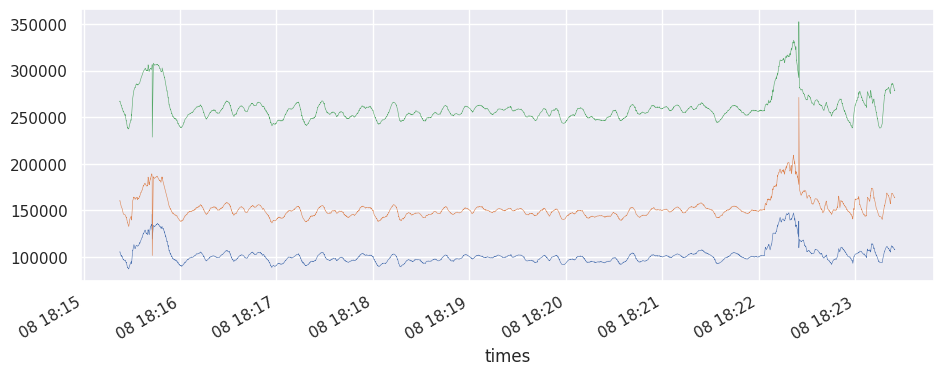

In [19]:
mplot = resting_verity['ppg0'].plot(linewidth = 0.4)
mplot = resting_verity['ppg1'].plot(linewidth = 0.4)
mplot = resting_verity['ppg2'].plot(linewidth = 0.4)

# plt.subplot()
# plt.plot(resting_verity['ppg0'])
# plt.plot(resting_verity['ppg1'])
# plt.plot(resting_verity['ppg2'])
# plt.savefig('test.png')

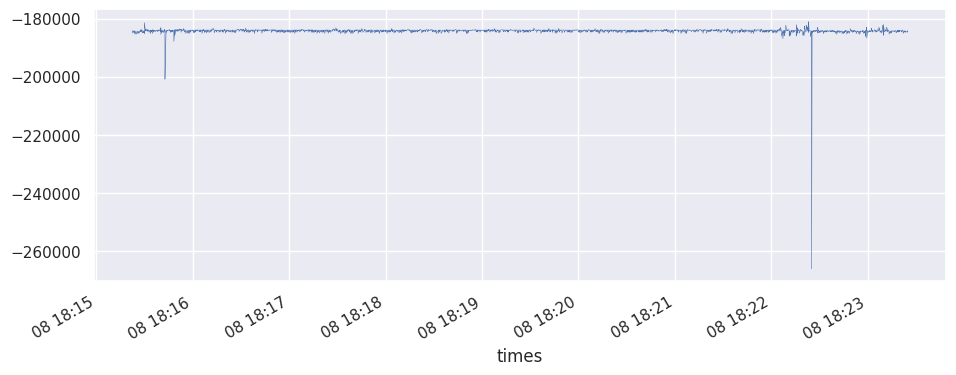

In [33]:
mplot = resting_verity['ambient'].plot(linewidth = 0.4)

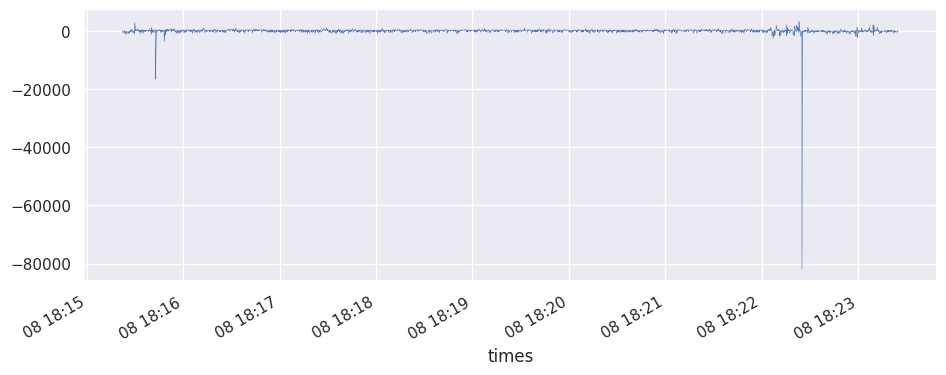

In [37]:
ambient_mean = resting_verity['ambient'].mean()
ambient_balance = resting_verity['ambient']-ambient_mean
mplot = ambient_balance.plot(linewidth = 0.4)

In [40]:
ppg0_mean = resting_verity['ppg0'].mean()
ppg1_mean = resting_verity['ppg1'].mean()
ppg2_mean = resting_verity['ppg2'].mean()

ppg0_balance1 = resting_verity['ppg0']-ppg0_mean
ppg1_balance1 = resting_verity['ppg1']-ppg1_mean
ppg2_balance1 = resting_verity['ppg2']-ppg2_mean
ppg0_balance2 = resting_verity['ppg0']/ppg0_mean
ppg1_balance2 = resting_verity['ppg1']/ppg1_mean
ppg2_balance2 = resting_verity['ppg2']/ppg2_mean
ppg0_balance_amb = ppg0_balance1 - ambient_balance
ppg1_balance_amb = ppg1_balance1 - ambient_balance
ppg2_balance_amb = ppg2_balance1 - ambient_balance

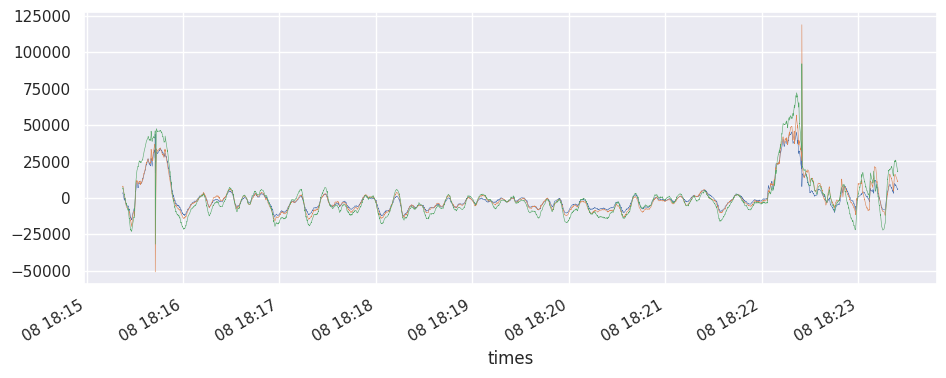

In [41]:
mplot = ppg0_balance1.plot(linewidth = 0.4) 
mplot = ppg1_balance1.plot(linewidth = 0.4) 
mplot = ppg2_balance1.plot(linewidth = 0.4)

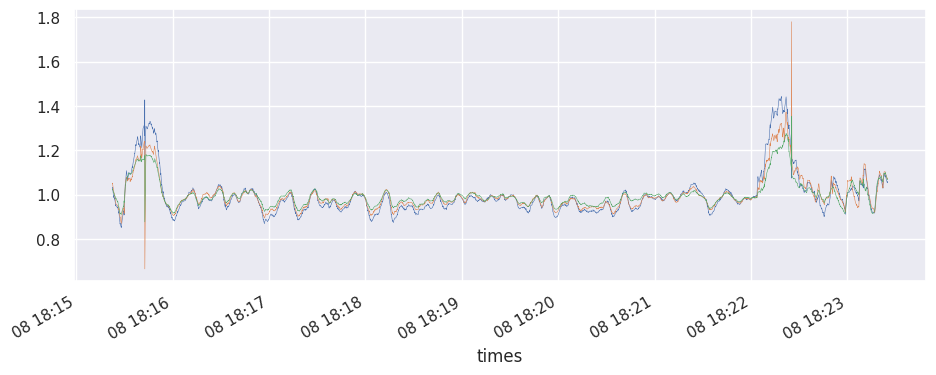

In [42]:
mplot = ppg0_balance2.plot(linewidth = 0.4) 
mplot = ppg1_balance2.plot(linewidth = 0.4) 
mplot = ppg2_balance2.plot(linewidth = 0.4)

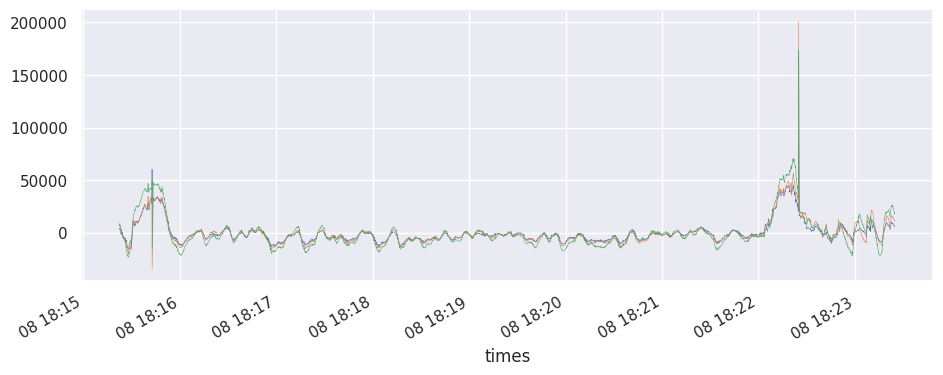

In [27]:
mplot = ppg0_balance_amb.plot(linewidth = 0.4) 
mplot = ppg1_balance_amb.plot(linewidth = 0.4) 
mplot = ppg2_balance_amb.plot(linewidth = 0.4)

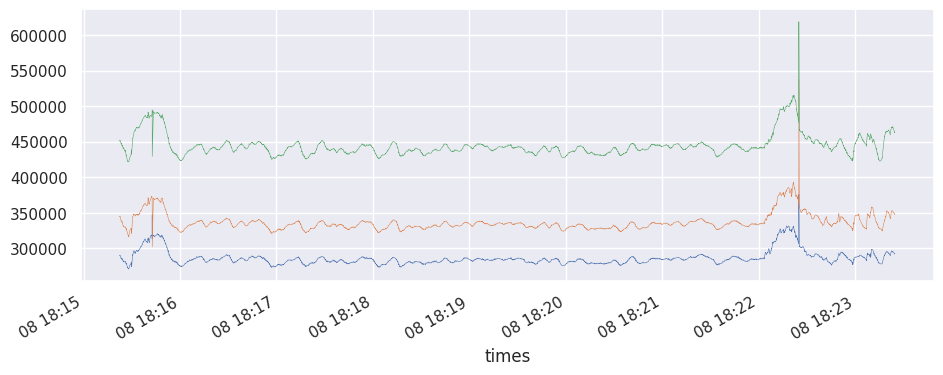

In [43]:
#pre subtracing version

mplot = (resting_verity['ppg0']-resting_verity['ambient']).plot(linewidth = 0.4)
mplot = (resting_verity['ppg1']-resting_verity['ambient']).plot(linewidth = 0.4)
mplot = (resting_verity['ppg2']-resting_verity['ambient']).plot(linewidth = 0.4)

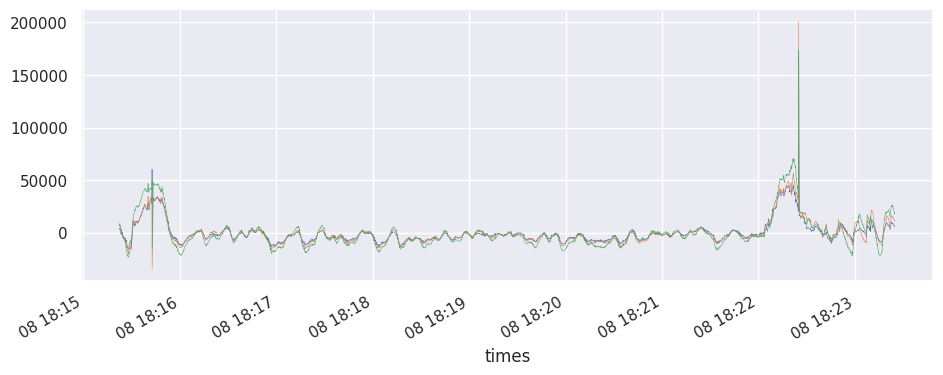

In [46]:
mplot = ((resting_verity['ppg0']-resting_verity['ambient'])-(resting_verity['ppg0']-resting_verity['ambient']).mean()).plot(linewidth = 0.4)
mplot = ((resting_verity['ppg1']-resting_verity['ambient'])-(resting_verity['ppg1']-resting_verity['ambient']).mean()).plot(linewidth = 0.4)
mplot = ((resting_verity['ppg2']-resting_verity['ambient'])-(resting_verity['ppg2']-resting_verity['ambient']).mean()).plot(linewidth = 0.4)

In [30]:
ppg0_spectrum = np.fft.rfft(ppg0_balance1)
ppg1_spectrum = np.fft.rfft(ppg1_balance1)
ppg2_spectrum = np.fft.rfft(ppg2_balance1)

<StemContainer object of 3 artists>

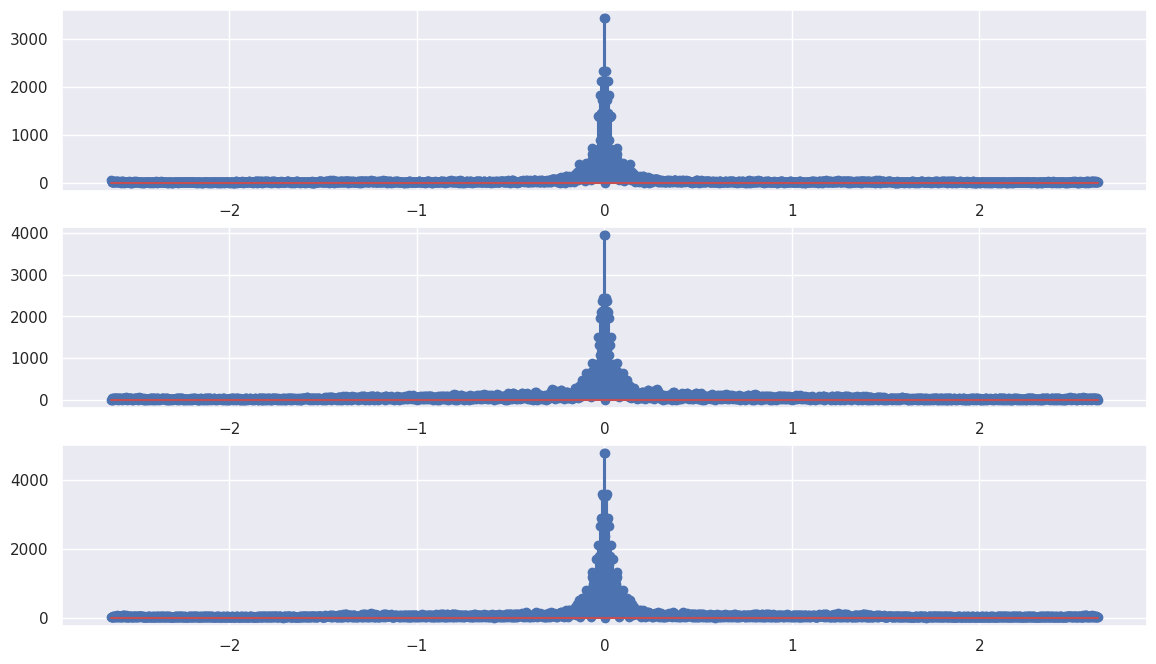

In [31]:
#verity 

fs = rest_verity_fs
length = len(ppg0_balance1)
f = np.linspace(-(fs / 2), fs / 2, length)

ppg0_fft = np.fft.fft(ppg0_balance1)/len(ppg0_balance1)
ppg1_fft = np.fft.fft(ppg1_balance1)/len(ppg1_balance1)
ppg2_fft = np.fft.fft(ppg2_balance1)/len(ppg2_balance1)

ppg0_fft_m = abs(ppg0_fft)
ppg1_fft_m = abs(ppg1_fft)
ppg2_fft_m = abs(ppg2_fft)
plt.figure(figsize=(14,8))

plt.subplot(3, 1, 1)
plt.stem(f, np.fft.fftshift(ppg0_fft_m))

plt.subplot(3, 1, 2)
plt.stem(f, np.fft.fftshift(ppg1_fft_m))

plt.subplot(3, 1, 3)
plt.stem(f, np.fft.fftshift(ppg2_fft_m))

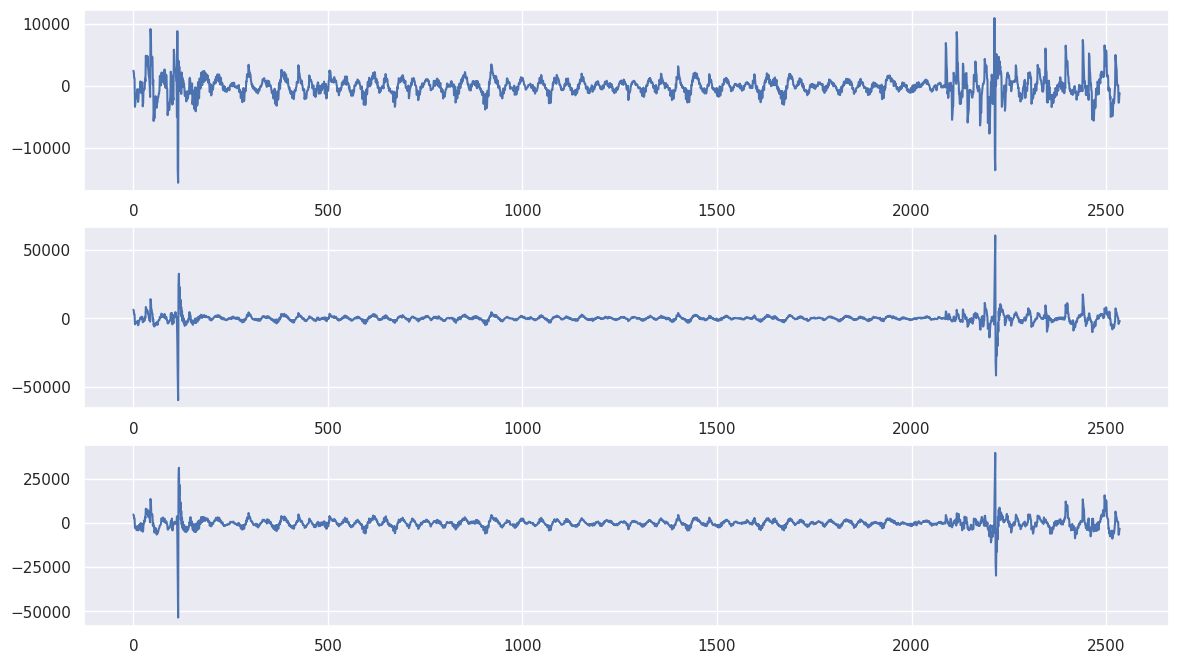

In [32]:
fs = rest_verity_fs
length = len(ppg0_balance1)
# 파라미터 계수 N
order = 2
#cutoff Wn
cutoff = [fs*0.03,fs/2*0.97]
# cutoff = [0.05,0.5]
ts = 1/ fs
Nyq = fs / 2

sos = signal.butter(order, cutoff,btype='bandpass', output = 'sos', fs = fs)

ppg0_filtered = signal.sosfilt(sos, ppg0_balance1)
ppg1_filtered = signal.sosfilt(sos, ppg1_balance1)
ppg2_filtered = signal.sosfilt(sos, ppg2_balance1)

plt.figure(figsize=(14,8))

plt.subplot(3, 1, 1)
plt.plot(ppg0_filtered)

plt.subplot(3, 1, 2)
plt.plot(ppg1_filtered)

plt.subplot(3, 1, 3)
plt.plot(ppg2_filtered)
# plt.plot(f, ppg2_filtered)

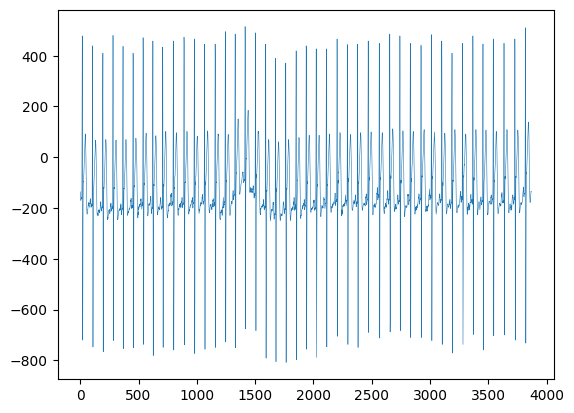

In [60]:
mplot = resting_h10['sensor'].plot(linewidth = 0.4)

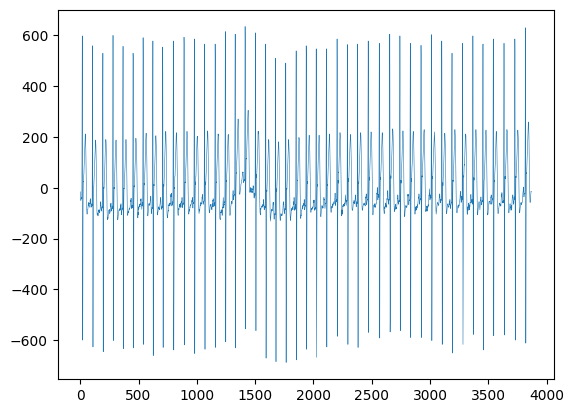

In [61]:
h_mean = resting_h10['sensor'].mean()

h_balance = resting_h10['sensor']-h_mean
mplot = h_balance.plot(linewidth = 0.4)

<StemContainer object of 3 artists>

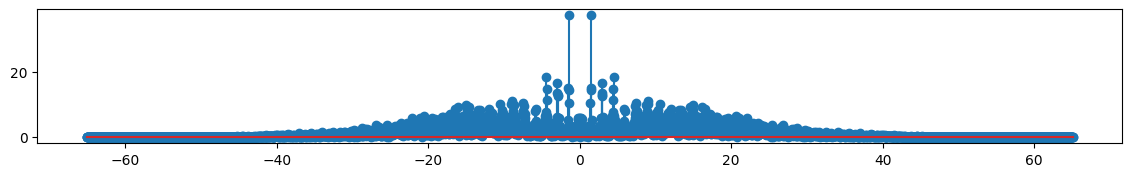

In [68]:
fs = rest_h10_fs
ts = 1/ fs
Nyq = fs / 2
length = len(h_balance)
f = np.linspace(-(fs / 2), fs / 2, length)

h10_fft = np.fft.fft(h_balance)/len(h_balance)
h10_fft_m = abs(h10_fft)
plt.figure(figsize=(14,8))
plt.subplot(4, 1, 1)
plt.stem(f, np.fft.fftshift(h10_fft_m))


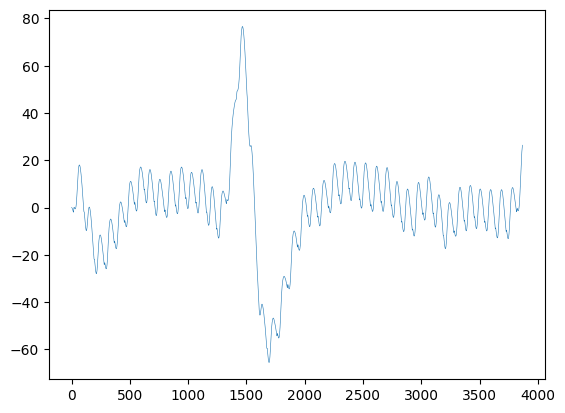

In [67]:
# 파라미터 계수 N
order = 2
#cutoff Wn
cutoff = [0.05,0.5]
sos = signal.butter(order, cutoff,btype='bandpass', output = 'sos', fs = fs)
h10_filtered = signal.sosfilt(sos, h_balance)
# plt.plot(h10_filtered)
plt.plot(h10_filtered, linewidth=0.4)

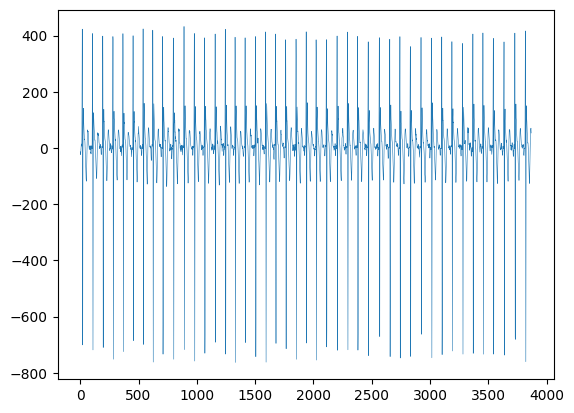

In [64]:
# 파라미터 계수 N
order = 2
#cutoff Wn
cutoff = [fs*0.03,fs/2*0.97]
ts = 1/ fs
Nyq = fs / 2
length = len(h_balance)
sos = signal.butter(order, cutoff,btype='bandpass', output = 'sos', fs = fs)

h10_filtered = signal.sosfilt(sos, h_balance)
# plt.plot(h10_filtered)
plt.plot(h10_filtered, linewidth=0.4)

In [267]:
# polar h10 ECG time domain features
time_domain = {
    #정상 범위 350~1500
    'mean_nni': 0,
    # 분포에서 20% 이상 날때 abnomal 판단(20%의 기준이 애매 재확인 필요)
    'sdnn': 0,
    #sd of diffrences between adjacent NN intervals
    'sdsd': 0,
    'nni_50': 0,
    'pnni_50': 0,
    'rmssd': 0,
    'median_nni': 0,
    'range_nni': 0,
    'cvsd': 0,
    'cvnni': 0,
    # 60초 내 횟수
    'mean_hr': 90,
    'max_hr': 140,
    'min_hr': 60,
    'std_hr': 15
}
# polar h10 ECG Frequency domain features
h10_param = ['RR', 'HRV_score', 'RMSSD', 'SDNN', 'pNN50', 'LF', 'HF', 'LF/HF')
# polar h10 ECG nonlinear domain features

SyntaxError: unterminated string literal (detected at line 8) (507047739.py, line 8)

In [43]:
스트레스 지수 계산식




SyntaxError: invalid syntax (2285762040.py, line 1)

In [ ]:
def data_merge():
    return
def data_save():